#### ** 完善的物理方程注释**
- 详细说明控制方程和边界条件
- 明确法向量方向和物理意义
- 添加数学公式和符号说明

#### ** 统一的结果保存机制**
- 所有评估结果保存到带时间戳的文件夹
- 包含：
  - 超参数配置 (JSON)
  - 误差统计表 (CSV)
  - 抽样对比数据 (CSV)
  - 2D 分析曲线 (PNG)
  - 3D 可视化 (HTML)
  - Loss 历史 (PNG + CSV)

---

### 📊 **训练数据集组成（已更新）**

| 采样器 | 数据源 | 采样点数 | 损失项 | 物理意义 |
|--------|--------|----------|--------|----------|
| `sampler_sensors` | 传感器数据 | 3216 | Data Loss | 拟合实验观测值 |
| `sampler_initial` | 全场 t=0 | 8482 | IC Loss | 初始温度约束 |
| `sampler_pde` | 全场域 | 20000 | PDE Loss | 物理方程约束 |
| `sampler_ends` | 端面 | 8000 | BC Loss (Ends) | 热流 + 对流边界 |
| `sampler_steps` | 台阶面 | 20000 | BC Loss (Steps) | 对流边界（重点） |
| `sampler_sides` | 侧面 | 8000 | BC Loss (Sides) | 对流边界 |
| **总计** | - | **67698** | **6项损失** | 数据 + 物理混合 |

---

### 🎯 **预期改进效果**

1. **初始条件约束**：消除时间演化的起点不确定性
2. **Loss 曲线监控**：及时发现过拟合/欠拟合，指导超参数调整
3. **更清晰的物理建模**：便于调试和论文撰写

---


# 三维阶梯轴 PINN 热传导预测 

本 Notebook 针对三段式阶梯轴的瞬态热传导问题建立 PINN 模型。
**物理场景**：
- 几何：三段轴 (D50, L150) + (D100, L700) + (D50, L150)。
- 材料：45号钢 (Steel45)。
- 边界条件：
    - **端面 (Ends)**：表面热流输入 ($q_n$) + 对流散热 ($h$)。
    - **侧面 (Sides)**：仅对流散热 ($h$)。
    - **台阶面 (Steps)**：仅对流散热 ($h$)。
- 训练数据：仅使用 16 个传感器点的温度数据 (SENSORS-N)。
- 验证数据：使用全场节点数据 (ALL-N)。
- 物理约束：在全场节点上施加 PDE 约束。


## 1. 数据加载与几何分组
我们将读取 `SENSORS-N.csv` (训练用) 和 `ALL-N.csv` (物理约束与验证用)。
为了施加正确的边界条件，我们需要将 `ALL-N` 中的节点根据几何坐标分类为：
1.  **内部/全场点 (Domain)**: 用于计算热传导 PDE 残差。
2.  **端面点 (Ends)**: $z=0$ 和 $z=1000$，施加 $q_n + h$ 边界。
3.  **侧面点 (Cylindrical Sides)**: $r=25$ 或 $r=50$ 的圆柱面，施加 $h$ 边界。
4.  **台阶面点 (Step Faces)**: $z=150$ 和 $z=850$ 的环形面，施加 $h$ 边界。


In [1]:
# 确保安装了用于 Plotly 显示的必要库
# 解决 ValueError: Mime type rendering requires nbformat>=4.2.0
import sys
!{sys.executable} -m pip install nbformat>=4.2.0 ipywidgets

from pathlib import Path
from typing import Tuple, Dict

import lightning.pytorch as pl
import numpy as np
import pandas as pd
import plotly.express as px
import torch

# 设置精度
torch.set_float32_matmul_precision("medium")

import pinnstorch
from pinnstorch.data import PointCloudData, PointCloud

# --- 配置路径 ---
NOTEBOOK_DIR = Path.cwd()
DATA_DIR = NOTEBOOK_DIR
SENSORS_CSV = DATA_DIR / "job4_temperatures__SENSORS-N.csv"
ALL_CSV = DATA_DIR / "job4_temperatures__ALL-N.csv"

# --- 辅助函数：DataFrame 转 PointCloudData (修正版: 适配 N x T 结构) ---
def dataframe_to_pointcloud(df: pd.DataFrame, solution_cols=["NT11"]) -> PointCloudData:
    if df.empty:
        raise ValueError("DataFrame 为空，无法创建 PointCloudData")
    
    # 确定节点唯一标识
    if "node_label" in df.columns and "instance" in df.columns:
        node_keys = ["instance", "node_label"]
    else:
        # 备选：使用坐标分组
        node_keys = ["x", "y", "z"]

    # 1. 提取唯一的时间步 (T, 1)
    times = np.sort(df["step_time"].unique())
    t_array = times[:, None].astype(np.float32)
    
    # 2. 提取唯一的空间节点 (N, 1)
    # 假设网格是固定的，取每个节点的第一个时间步坐标
    nodes = df.groupby(node_keys)[["x", "y", "z"]].first().reset_index()
    x_array = nodes["x"].values[:, None].astype(np.float32)
    y_array = nodes["y"].values[:, None].astype(np.float32)
    z_array = nodes["z"].values[:, None].astype(np.float32)
    
    # 3. 构建解矩阵 (N, T)
    solution = {}
    for col in solution_cols:
        if col in df.columns:
            # Pivot: 行=节点, 列=时间
            pivot = df.pivot_table(index=node_keys, columns="step_time", values=col)
            # 确保列顺序与 times 一致
            pivot = pivot.reindex(columns=times)
            # 填充可能的缺失值 (前向+后向填充)
            if pivot.isnull().values.any():
                pivot = pivot.ffill(axis=1).bfill(axis=1)
            
            solution["T"] = pivot.values.astype(np.float32)
            
    # 打印形状信息以便调试
    print(f"  -> PointCloudData shapes: Spatial={x_array.shape}, Time={t_array.shape}, Solution={solution['T'].shape if 'T' in solution else 'None'}")
            
    return PointCloudData(spatial=[x_array, y_array, z_array], time=[t_array], solution=solution)

def build_point_cloud(df: pd.DataFrame, root_dir=str(DATA_DIR)) -> PointCloud:
    pc_data = dataframe_to_pointcloud(df)
    return PointCloud(root_dir=root_dir, read_data_fn=lambda _: pc_data)

# --- 1. 读取数据 ---
print("正在读取 CSV 文件...")
sensors_df = pd.read_csv(SENSORS_CSV)
all_df = pd.read_csv(ALL_CSV)

# --- 2. 几何分组逻辑 ---
TOL = 1.0 # 几何容差 (mm)

# 计算半径
all_df["r"] = np.sqrt(all_df["x"]**2 + all_df["y"]**2)

# (1) 端面: z=0 或 z=1000
mask_ends = np.isclose(all_df["z"], 0, atol=TOL) | np.isclose(all_df["z"], 1000, atol=TOL)

# (2) 台阶面: z=150 或 z=850，且半径在 25~50 之间
mask_steps = (np.isclose(all_df["z"], 150, atol=TOL) | np.isclose(all_df["z"], 850, atol=TOL)) & (all_df["r"] > 25 + TOL)

# (3) 侧面: 
#   Section 1 & 3: r=25, 0 < z < 150 或 850 < z < 1000
#   Section 2: r=50, 150 < z < 850
mask_side_small = np.isclose(all_df["r"], 25, atol=TOL) & ((all_df["z"] > -TOL) & (all_df["z"] < 150+TOL) | (all_df["z"] > 850-TOL) & (all_df["z"] < 1000+TOL))
mask_side_large = np.isclose(all_df["r"], 50, atol=TOL) & (all_df["z"] > 150-TOL) & (all_df["z"] < 850+TOL)
mask_sides = mask_side_small | mask_side_large

# 排除掉已经被归类为 Ends 或 Steps 的点
mask_sides = mask_sides & (~mask_ends) & (~mask_steps)

# 提取 DataFrame
df_ends = all_df[mask_ends].copy()
df_steps = all_df[mask_steps].copy()
df_sides = all_df[mask_sides].copy()
df_domain = all_df.copy() # 全场点用于 PDE

print(f"数据统计 (Rows):")
print(f"  传感器点 (训练数据): {len(sensors_df)}")
print(f"  全场点 (PDE 约束): {len(df_domain)}")
print(f"  端面点 (BC: Flux+Conv): {len(df_ends)}")
print(f"  台阶面点 (BC: Conv): {len(df_steps)}")
print(f"  侧面点 (BC: Conv): {len(df_sides)}")

# --- 3. 构建 PointCloud 对象 ---
print("\n构建 PointCloud 对象...")
print("Sensors:")
cloud_sensors = build_point_cloud(sensors_df)

print("Domain (PDE):")
cloud_domain = build_point_cloud(df_domain)

print("Ends (BC):")
cloud_ends = build_point_cloud(df_ends)

print("Steps (BC):")
cloud_steps = build_point_cloud(df_steps)

print("Sides (BC):")
cloud_sides = build_point_cloud(df_sides)

# 获取归一化边界 (从全场数据获取)
lb = cloud_domain.lb
ub = cloud_domain.ub
print(f"\n归一化范围: lb={lb}, ub={ub}")

正在读取 CSV 文件...
数据统计 (Rows):
  传感器点 (训练数据): 3216
  全场点 (PDE 约束): 1704882
  端面点 (BC: Flux+Conv): 13266
  台阶面点 (BC: Conv): 27336
  侧面点 (BC: Conv): 546720

构建 PointCloud 对象...
Sensors:
  -> PointCloudData shapes: Spatial=(16, 1), Time=(201, 1), Solution=(16, 201)
Domain (PDE):
数据统计 (Rows):
  传感器点 (训练数据): 3216
  全场点 (PDE 约束): 1704882
  端面点 (BC: Flux+Conv): 13266
  台阶面点 (BC: Conv): 27336
  侧面点 (BC: Conv): 546720

构建 PointCloud 对象...
Sensors:
  -> PointCloudData shapes: Spatial=(16, 1), Time=(201, 1), Solution=(16, 201)
Domain (PDE):
  -> PointCloudData shapes: Spatial=(8482, 1), Time=(201, 1), Solution=(8482, 201)
Ends (BC):
  -> PointCloudData shapes: Spatial=(66, 1), Time=(201, 1), Solution=(66, 201)
Steps (BC):
  -> PointCloudData shapes: Spatial=(136, 1), Time=(201, 1), Solution=(136, 201)
Sides (BC):
  -> PointCloudData shapes: Spatial=(8482, 1), Time=(201, 1), Solution=(8482, 201)
Ends (BC):
  -> PointCloudData shapes: Spatial=(66, 1), Time=(201, 1), Solution=(66, 201)
Steps (BC):
  ->

## 2. 物理参数定义
根据实验设置定义材料参数和边界条件参数。
注意单位系统：
- 长度: mm
- 时间: s
- 功率: mW (由 k=48, q=20 推断)
- 质量: tonne
- 温度: ℃


In [ ]:
# 材料参数 (Steel 45)
# rho: 7.9e-9 tonne/mm^3
# cp: 4.5e8 mJ/(tonne C)
# k: 48 mW/(mm C)
rho = 7.9e-09
cp = 4.5e8
k = 48.0

# 边界条件参数
# q_n: 2对流系数)
# T_inf: 20 C (环境温度)
q_n = 20.0
h = 0.0085
T_inf = 20.0

print(f"热扩散系数 alpha = k/(rho*cp) = {k/(rho*cp):.4f} mm^2/s")


热扩散系数 alpha = k/(rho*cp) = 13.5021 mm^2/s


## 3. 定义神经网络
使用全连接网络 (FCN)，输入 `(x, y, z, t)`，输出 `T`。


In [3]:
from pinnstorch.models import FCN

# 输入 4 维 (x,y,z,t)，输出 1 维 (T)
# 隐藏层结构: [4, 128, 128, 128, 128, 128, 1]
layers = [4, 128, 128, 128, 128, 1]

net = FCN(
    layers=layers,
    output_names=['T'],
    lb=lb,
    ub=ub
)
print(net)


FCN(
  (model): Sequential(
    (input): Linear(in_features=4, out_features=128, bias=True)
    (activation_1): Tanh()
    (hidden_2): Linear(in_features=128, out_features=128, bias=True)
    (activation_2): Tanh()
    (hidden_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): Tanh()
    (hidden_4): Linear(in_features=128, out_features=128, bias=True)
    (activation_4): Tanh()
    (output): Linear(in_features=128, out_features=1, bias=True)
  )
)


## 4. 定义物理方程 (PDE & BCs)

### 📐 **物理建模说明**

这是 PINN 的核心。我们需要定义一个 `pde_fn`，它计算并返回：

1.  **`f_T`**: 内部热传导方程残差（PDE）
2.  **`f_bc_ends`**: 端面边界残差（热流输入 + 对流散热）
3.  **`f_bc_sides`**: 侧面边界残差（对流散热）
4.  **`f_bc_steps`**: 台阶面边界残差（对流散热）

---

### 🔬 **控制方程**

**三维瞬态热传导方程**：
$$
\rho c_p \frac{\partial T}{\partial t} = k \nabla^2 T = k \left( \frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2} + \frac{\partial^2 T}{\partial z^2} \right)
$$

---

### 🌡️ **边界条件**

#### **1. 端面（z = 0, z = 1000）- 热流输入 + 对流散热**

$$
k \frac{\partial T}{\partial n} = q_n - h(T - T_{\infty})
$$

- **左端面（z=0）**：法向量 $\vec{n} = (0, 0, -1)$
- **右端面（z=1000）**：法向量 $\vec{n} = (0, 0, +1)$
- **物理意义**：外部加热（$q_n = 20 \text{ mW/mm}^2$）与对流散热的平衡

---

#### **2. 台阶面（z = 150, z = 850）- 对流散热**

$$
k \frac{\partial T}{\partial n} = -h(T - T_{\infty})
$$

- **左台阶（z=150）**：法向量 $\vec{n} = (0, 0, -1)$
- **右台阶（z=850）**：法向量 $\vec{n} = (0, 0, +1)$
- **物理意义**：环形台阶面暴露在环境中，发生对流散热

---

#### **3. 圆柱侧面 - 对流散热**

$$
k \frac{\partial T}{\partial n} = -h(T - T_{\infty})
$$

- **细轴侧面**：$r = 25 \text{ mm}$，法向量 $\vec{n} = \left(\frac{x}{r}, \frac{y}{r}, 0\right)$
- **粗轴侧面**：$r = 50 \text{ mm}$，法向量 $\vec{n} = \left(\frac{x}{r}, \frac{y}{r}, 0\right)$
- **物理意义**：圆柱表面与环境的对流换热

---

### ⚖️ **法向导数计算**

对于边界条件，关键是计算**法向导数** $\frac{\partial T}{\partial n} = \vec{n} \cdot \nabla T$：

- **轴向边界**（端面、台阶面）：$\frac{\partial T}{\partial n} = \pm \frac{\partial T}{\partial z}$
- **径向边界**（侧面）：$\frac{\partial T}{\partial n} = \frac{1}{r}\left( x \frac{\partial T}{\partial x} + y \frac{\partial T}{\partial y} \right)$

---

### 🎛️ **权重策略**

由于台阶面是几何突变处，预测难度大，我们采用**差异化权重**：

- **PDE 权重**：5.0（控制物理方程的重要性）
- **一般边界**（端面、侧面）：0.15（适中权重）
- **台阶边界**：0.25（**加强权重**，提高对困难区域的关注）


In [4]:
# --- 权重超参数 (Global Hyperparameters) ---
PDE_WEIGHT = 5
BC_SCALE_GENERAL = 0.3
BC_SCALE_STEPS = 1.0 

def heat_pde_fn(outputs, x, y, z, t, extra_variables=None):
    """
    计算三维瞬态热传导 PDE 和边界条件残差。
    
    控制方程:
        ρ·cp·∂T/∂t = k·∇²T
        
    边界条件:
        - 端面 (z=0, z=1000): k·∂T/∂n = q_n - h·(T - T_inf)  (热流输入 + 对流散热)
        - 台阶面 (z=150, z=850): k·∂T/∂n = -h·(T - T_inf)  (对流散热)
        - 侧面 (圆柱面): k·∂T/∂n = -h·(T - T_inf)  (对流散热)
        
    法向量约定:
        - 端面: z=0 → n̂=(-z), z=1000 → n̂=(+z)
        - 台阶面: z=150 → n̂=(-z), z=850 → n̂=(+z)
        - 侧面: n̂=(x/r, y/r, 0) 指向径向外
    """
    T = outputs["T"]
    
    # 1. 计算一阶导数 (x, y, z, t)
    grads = pinnstorch.utils.gradient(T, [x, y, z, t])
    T_x, T_y, T_z, T_t = grads[0], grads[1], grads[2], grads[3]
    
    # 2. 计算二阶导数 (Laplacian: ∇²T = ∂²T/∂x² + ∂²T/∂y² + ∂²T/∂z²)
    T_xx = pinnstorch.utils.gradient(T_x, x)[0]
    T_yy = pinnstorch.utils.gradient(T_y, y)[0]
    T_zz = pinnstorch.utils.gradient(T_z, z)[0]
    
    # --- PDE Residual (内部域) ---
    # Eq: ρ·cp·∂T/∂t = k·∇²T
    # 残差 = ρ·cp·∂T/∂t - k·∇²T  (理想情况下应为 0)
    pde_res = rho * cp * T_t - k * (T_xx + T_yy + T_zz)
    outputs["f_T"] = pde_res * PDE_WEIGHT 
    
    # --- 辅助变量 ---
    r = torch.sqrt(x**2 + y**2)
    
    # --- Boundary Residuals ---
    # 策略: 差异化赋权 (Differential Weighting)
    # 1. 普通区域 (Ends, Sides) 保持适中权重，避免干扰数据拟合
    # 2. 困难区域 (Steps) 给予高权重，强制模型关注几何突变处
    
    # (A) 端面边界条件 (z=0, z=1000)
    # BC: k·∂T/∂n = q_n - h·(T - T_inf)
    # 法向导数: ∂T/∂n = n̂·∇T
    #   - z=0:  n̂=(0,0,-1) → ∂T/∂n = -∂T/∂z
    #   - z=1000: n̂=(0,0,+1) → ∂T/∂n = +∂T/∂z
    dT_dn_ends = torch.where(z < 500.0, -T_z, T_z)
    bc_res_ends = k * dT_dn_ends - (q_n - h * (T - T_inf))
    outputs["f_bc_ends"] = bc_res_ends * BC_SCALE_GENERAL
    
    # (B) 台阶面边界条件 (z=150, z=850)
    # BC: k·∂T/∂n = -h·(T - T_inf)  (纯对流散热，无外部热流)
    # 法向导数: 同端面
    dT_dn_steps = torch.where(z < 500.0, -T_z, T_z)
    bc_res_steps = k * dT_dn_steps - (0.0 - h * (T - T_inf))
    outputs["f_bc_steps"] = bc_res_steps * BC_SCALE_STEPS
    
    # (C) 圆柱侧面边界条件
    # BC: k·∂T/∂n = -h·(T - T_inf)
    # 法向导数: n̂=(x/r, y/r, 0) → ∂T/∂n = (∂T/∂x·x + ∂T/∂y·y) / r
    dT_dn_sides = (T_x * x + T_y * y) / (r + 1e-6)
    bc_res_sides = k * dT_dn_sides - (0.0 - h * (T - T_inf))
    outputs["f_bc_sides"] = bc_res_sides * BC_SCALE_GENERAL
    
    return outputs

# --- 输出变换函数 ---
def output_transform(outputs, x, y, z, t):
    """
    输出后处理：使用 Sigmoid 限制温度在物理合理范围内。
    
    原始输出 → Sigmoid(·) → 映射到 [20, 100]°C
    
    这样可以防止模型预测出负温度或超出加热范围的极端值。
    """
    outputs["T"] = torch.sigmoid(outputs["T"]) * 80.0 + 20.0
    return outputs


## 5. 构建 DataModule 与 Model

### 📋 **更新说明（2025-11-22）**

**新增功能**：
1. ✅ **初始条件采样器** (`InitialCondition`)
   - 在 t=0 时刻施加 T(x,y,z,0) = 20°C 的约束
   - 采样 5000 个初始条件点，确保瞬态问题的正确起点
   
2. ✅ **详细 Loss 曲线记录** (`LossHistoryCallback`)
   - 记录每个 epoch 的训练损失、验证损失、学习率
   - 自动绘制 4 张分析图：总损失、学习率、最近损失趋势
   - 保存 Loss 历史数据到 CSV 文件
   
3. ✅ **完整的训练流程**
   - 自动保存最佳模型（基于验证集 Loss）
   - 训练结束后自动加载最佳权重
   - 所有评估结果统一保存到带时间戳的文件夹

### 🎯 **训练数据集组成**

我们将创建多个 `MeshSampler`，分别对应不同的损失项：

1.  **`sampler_sensors`**: 采样 `cloud_sensors`（16个传感器 × 200时间步），目标是 `T` (数据损失)
2.  **`sampler_initial`**: 采样 `cloud_domain` 在 t=0 时刻，目标是 `T=20°C` (初始条件损失) 
3.  **`sampler_pde`**: 采样 `cloud_domain`，目标是 `f_T` (PDE 损失)
4.  **`sampler_ends`**: 采样 `cloud_ends`，目标是 `f_bc_ends` (端面边界损失)
5.  **`sampler_steps`**: 采样 `cloud_steps`，目标是 `f_bc_steps` (台阶面边界损失)
6.  **`sampler_sides`**: 采样 `cloud_sides`，目标是 `f_bc_sides` (侧面边界损失)


In [5]:
from pinnstorch.data import MeshSampler, PINNDataModule, InitialCondition
from pinnstorch.models import PINNModule
import torch
from functools import partial

# ==================== 自定义 PINNModule 以记录损失分量 ====================
class PINNModuleWithLossLogging(PINNModule):
    """扩展 PINNModule 以记录各个损失分量"""
    
    def __init__(self, *args, loss_label_map=None, **kwargs):
        super().__init__(*args, **kwargs)
        # 用于存储当前 step 的损失分量
        self.loss_components = {}
        self.loss_label_map = loss_label_map or {}
    
    def model_step(self, batch):
        """重写 model_step 以记录各个损失分量"""
        loss = 0.0
        self.loss_components = {}  # 重置
        
        from pinnstorch.utils.module_fn import set_requires_grad
        
        for loss_fn_name, data in batch.items():
            x, t, u = data
            x, t = set_requires_grad(x, t, True)
            
            # 记录当前损失函数之前的总损失
            loss_before = loss if isinstance(loss, torch.Tensor) else 0.0
            
            # 调用损失函数
            loss, preds = self.function_mapping[loss_fn_name](data, loss, self.functions)
            
            # 计算这个损失函数的贡献
            loss_contribution = loss - loss_before if isinstance(loss_before, torch.Tensor) else loss
            label = self.loss_label_map.get(loss_fn_name, loss_fn_name)
            value = loss_contribution.item() if isinstance(loss_contribution, torch.Tensor) else loss_contribution
            self.loss_components[label] = value
            
        return loss, preds

# 采样数量配置
# 增加采样点数以提高对复杂几何区域（如台阶面、粗轴）的覆盖率
N_SENSORS = len(sensors_df) # 全部用上
N_PDE = 20000    # PDE 配点数
N_BC_ENDS = 8000     # 端面边界配点数
N_BC_STEPS = 20000     # 台阶面边界配点数
N_BC_SIDES = 8000     # 侧面边界配点数

# 1. 初始条件采样器 (新增)
# 在 t=0 时刻，整个轴的温度为 20°C
def initial_temperature(spatial_domain):
    """
    初始条件函数：T(x,y,z,t=0) = 20°C
    
    参数:
        spatial_domain: numpy array of shape (N, 3), 包含 [x, y, z] 坐标
    
    返回:
        字典 {'T': numpy array of shape (N, 1)}
    """
    # spatial_domain 的形状是 (N, 3)，我们只需要知道有多少个点
    num_points = spatial_domain.shape[0]
    return {'T': np.ones((num_points, 1), dtype=np.float32) * T_inf}

sampler_initial = InitialCondition(
    mesh=cloud_domain,
    num_sample=8482,  # 采样8482个初始条件点
    initial_fun=initial_temperature,
    solution=['T']
)

# 2. 数据损失采样器（传感器数据）
sampler_sensors = MeshSampler(
    mesh=cloud_sensors,
    num_sample=N_SENSORS,
    solution=['T']
)

# 3. PDE 损失采样器
sampler_pde = MeshSampler(
    mesh=cloud_domain,
    num_sample=N_PDE,
    collection_points=['f_T']
)

# 4. 边界条件采样器
sampler_ends = MeshSampler(
    mesh=cloud_ends,
    num_sample=N_BC_ENDS,
    collection_points=['f_bc_ends']
)

sampler_steps = MeshSampler(
    mesh=cloud_steps,
    num_sample=N_BC_STEPS,
    collection_points=['f_bc_steps']
)

sampler_sides = MeshSampler(
    mesh=cloud_sides,
    num_sample=N_BC_SIDES,
    collection_points=['f_bc_sides']
)

LOSS_LABEL_MAP = {
    str(sampler_sensors.loss_fn): 'train_loss_data',
    str(sampler_initial.loss_fn): 'train_loss_ic',
    str(sampler_pde.loss_fn): 'train_loss_pde',
    str(sampler_ends.loss_fn): 'train_loss_bc_ends',
    str(sampler_steps.loss_fn): 'train_loss_bc_steps',
    str(sampler_sides.loss_fn): 'train_loss_bc_sides',
}

# 验证集 (使用台阶面数据验证，因为这是最困难的区域)
val_sampler = MeshSampler(
    mesh=cloud_domain,
    solution=['T']
)

# 构建 DataModule
datamodule = PINNDataModule(
    train_datasets=[sampler_sensors, sampler_initial, sampler_pde, sampler_ends, sampler_steps, sampler_sides],
    val_dataset=val_sampler,
    pred_dataset=val_sampler,
    batch_size=None # Full batch for PINNs usually
)

# 定义优化器，设置初始学习率为 1e-4
optimizer = partial(torch.optim.Adam, lr=1e-4)
# 定义学习率调度器: 每 2000 epoch 衰减为原来的 0.5
# scheduler = partial(torch.optim.lr_scheduler.StepLR, step_size=2000, gamma=0.5)

# 构建 Model（使用自定义的 PINNModule）
model = PINNModuleWithLossLogging(
    net=net,
    pde_fn=heat_pde_fn,
    output_fn=output_transform,
    optimizer=optimizer,
    # scheduler=scheduler,
    loss_fn='mse',
    jit_compile=False, 
    cudagraph_compile=False,
    loss_label_map=LOSS_LABEL_MAP,
)

print(f"\n训练数据集配置:")
print(f"  1. 传感器数据 (Data Loss): {N_SENSORS} 点")
print(f"  2. 初始条件 (IC Loss): 8482 点")
print(f"  3. PDE 残差 (PDE Loss): {N_PDE} 点")
print(f"  4. 端面边界 (BC Ends): {min(len(df_ends), N_BC_ENDS)} 点")
print(f"  5. 台阶面边界 (BC Steps): {min(len(df_steps), N_BC_STEPS)} 点")
print(f"  6. 侧面边界 (BC Sides): {min(len(df_sides), N_BC_SIDES)} 点")
print(f"  总计: {N_SENSORS + 8482 + N_PDE + N_BC_SIDES + N_BC_ENDS + N_BC_STEPS} 点")



训练数据集配置:
  1. 传感器数据 (Data Loss): 3216 点
  2. 初始条件 (IC Loss): 8482 点
  3. PDE 残差 (PDE Loss): 20000 点
  4. 端面边界 (BC Ends): 8000 点
  5. 台阶面边界 (BC Steps): 20000 点
  6. 侧面边界 (BC Sides): 8000 点
  总计: 67698 点


In [6]:
# Trainer 配置与自定义 Loss 记录
from lightning.pytorch.callbacks import ModelCheckpoint, Callback
import matplotlib.pyplot as plt
import datetime

# 增加 Epochs 以确保在新的权重下充分收敛
MAX_EPOCHS = 8000

# 创建带时间戳的训练会话文件夹
WEIGHTS_ROOT_DIR = NOTEBOOK_DIR / "weights"
WEIGHTS_ROOT_DIR.mkdir(exist_ok=True)

# 为本次训练创建唯一的文件夹
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
WEIGHTS_DIR = WEIGHTS_ROOT_DIR / f"train_{timestamp}"
WEIGHTS_DIR.mkdir(exist_ok=True)
print(f"本次训练权重将保存至: {WEIGHTS_DIR}")

# ==================== 自定义 Callback：记录详细 Loss ==================== 
class LossHistoryCallback(Callback):
    """记录训练过程中的各项损失，用于详细分析"""
    
    def __init__(self, loss_label_map=None):
        super().__init__()
        self.loss_label_map = loss_label_map or {}
        self.unknown_keys_logged = set()
        self.history = {
            'epoch': [],
            'train_loss_total': [],
            'train_loss_data': [],      # 传感器数据损失
            'train_loss_ic': [],         # 初始条件损失
            'train_loss_pde': [],        # PDE 残差损失
            'train_loss_bc_ends': [],    # 端面边界损失
            'train_loss_bc_steps': [],   # 台阶面边界损失
            'train_loss_bc_sides': [],   # 侧面边界损失
            'val_loss': [],
            'val_epoch': [],             # 记录验证发生的epoch
            'learning_rate': []
        }
    
    def on_train_epoch_end(self, trainer, pl_module):
        """每个训练 epoch 结束时记录损失"""
        epoch = trainer.current_epoch
        # 初始化本轮的损失分量为0（用于累加）
        epoch_components = {
            'train_loss_data': 0.0,
            'train_loss_ic': 0.0,
            'train_loss_pde': 0.0,
            'train_loss_bc_ends': 0.0,
            'train_loss_bc_steps': 0.0,
            'train_loss_bc_sides': 0.0
        }
        
        # 记录各个损失分量（从自定义 PINNModule 获取）
        if hasattr(pl_module, 'loss_components') and pl_module.loss_components:
            components = pl_module.loss_components
            
            # 在第一个epoch打印损失函数的键名，方便调试
            if epoch == 0:
                print(f"\n检测到的损失函数键名:")
                for key in components.keys():
                    print(f"  - {key}")
                print()
            
            for key, value in components.items():
                label = self.loss_label_map.get(key, key)
                if label in epoch_components:
                    epoch_components[label] += value
                else:
                    if label not in self.unknown_keys_logged:
                        print(f"[LossHistoryCallback] 未识别的损失键: {label}")
                        self.unknown_keys_logged.add(label)
        
        # 记录总损失
        if 'train/loss' in trainer.callback_metrics:
            total_loss = trainer.callback_metrics['train/loss'].item()
            self.history['train_loss_total'].append(total_loss)
        
        # 记录本轮的损失分量（如果为0则记录None）
        for key in ['train_loss_data', 'train_loss_ic', 'train_loss_pde', 
                    'train_loss_bc_ends', 'train_loss_bc_steps', 'train_loss_bc_sides']:
            value = epoch_components[key]
            self.history[key].append(value if value > 0 else None)
        
        # 记录学习率
        if trainer.optimizers:
            lr = trainer.optimizers[0].param_groups[0]['lr']
            self.history['learning_rate'].append(lr)
        
        self.history['epoch'].append(epoch)
    
    def on_validation_epoch_end(self, trainer, pl_module):
        """验证结束时记录验证损失"""
        if 'val/loss' in trainer.callback_metrics:
            val_loss = trainer.callback_metrics['val/loss'].item()
            self.history['val_loss'].append(val_loss)
            self.history['val_epoch'].append(trainer.current_epoch)
    
    def plot_and_save(self, save_dir):
        """绘制并保存所有 Loss 曲线"""
        import seaborn as sns
        sns.set_theme(style="whitegrid", context="notebook")
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        epochs = self.history['epoch']
        
        # 1. 总损失曲线（训练 + 验证）
        ax1 = axes[0, 0]
        if self.history['train_loss_total']:
            ax1.semilogy(epochs, self.history['train_loss_total'], 
                        label='Train Loss', linewidth=2, color='#1f77b4')
        if self.history['val_loss'] and self.history['val_epoch']:
            # 使用实际记录的验证epoch
            ax1.semilogy(self.history['val_epoch'], 
                        self.history['val_loss'], 
                        label='Val Loss', linewidth=2, color='#ff7f0e', 
                        marker='o', markersize=4)
        ax1.set_xlabel('Epoch', fontsize=12)
        ax1.set_ylabel('Loss (log scale)', fontsize=12)
        ax1.set_title('Total Loss (Train & Validation)', fontsize=14, fontweight='bold')
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3)
        
        # 2. 学习率曲线
        ax2 = axes[0, 1]
        if self.history['learning_rate']:
            ax2.semilogy(epochs, self.history['learning_rate'], 
                        linewidth=2, color='green')
            ax2.set_xlabel('Epoch', fontsize=12)
            ax2.set_ylabel('Learning Rate (log scale)', fontsize=12)
            ax2.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
            ax2.grid(True, alpha=0.3)
        
        # 3. 训练损失详细分解
        ax3 = axes[1, 0]
        
        # 绘制各个损失分量
        has_component_data = any([
            self.history.get('train_loss_data'),
            self.history.get('train_loss_ic'),
            self.history.get('train_loss_pde'),
            self.history.get('train_loss_bc_ends'),
            self.history.get('train_loss_bc_steps'),
            self.history.get('train_loss_bc_sides')
        ])
        
        if has_component_data:
            # 定义各分量的颜色和标签
            components = [
                ('train_loss_data', 'Data Loss (Sensors)', '#1f77b4'),
                ('train_loss_ic', 'IC Loss', '#ff7f0e'),
                ('train_loss_pde', 'PDE Loss', '#2ca02c'),
                ('train_loss_bc_ends', 'BC Loss (Ends)', '#d62728'),
                ('train_loss_bc_steps', 'BC Loss (Steps)', '#9467bd'),
                ('train_loss_bc_sides', 'BC Loss (Sides)', '#8c564b'),
            ]
            
            for key, label, color in components:
                if key in self.history and self.history[key]:
                    # 过滤掉 None 值
                    data = [(i, v) for i, v in enumerate(self.history[key]) if v is not None]
                    if data:
                        epochs_idx, values = zip(*data)
                        epochs_actual = [self.history['epoch'][i] for i in epochs_idx]
                        ax3.semilogy(epochs_actual, values, linewidth=2, label=label, color=color, alpha=0.8)
            
            ax3.set_xlabel('Epoch', fontsize=12)
            ax3.set_ylabel('Loss (log scale)', fontsize=12)
            ax3.set_title('Loss Components', fontsize=14, fontweight='bold')
            ax3.legend(fontsize=9, loc='best')
            ax3.grid(True, alpha=0.3)
        else:
            # 如果没有分量数据，显示说明
            ax3.text(0.5, 0.5, 
                    '损失分量记录未启用\n'
                    '请确保使用 PINNModuleWithLossLogging',
                    ha='center', va='center', fontsize=12, color='gray')
            ax3.set_title('Loss Components', fontsize=14, fontweight='bold')
            ax3.axis('off')
        
        # 4. 训练损失（最近 500 epochs 的线性尺度）
        ax4 = axes[1, 1]
        if len(epochs) > 500:
            recent_epochs = epochs[-500:]
            recent_loss = self.history['train_loss_total'][-500:]
        else:
            recent_epochs = epochs
            recent_loss = self.history['train_loss_total']
        
        if recent_loss:
            ax4.plot(recent_epochs, recent_loss, linewidth=2, color='#d62728')
            ax4.set_xlabel('Epoch', fontsize=12)
            ax4.set_ylabel('Loss (linear scale)', fontsize=12)
            ax4.set_title(f'Recent Training Loss (Last {len(recent_epochs)} epochs)', 
                         fontsize=14, fontweight='bold')
            ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        # 保存图像
        loss_plot_path = save_dir / "loss_curves.png"
        plt.savefig(loss_plot_path, dpi=300, bbox_inches='tight')
        print(f"✅ 已保存 Loss 曲线: {loss_plot_path}")
        plt.close()
        
        # 保存 Loss 历史数据（CSV）
        import pandas as pd
        history_df = pd.DataFrame({
            'epoch': self.history['epoch'],
            'train_loss': self.history['train_loss_total'],
            'learning_rate': self.history['learning_rate']
        })
        
        # 添加损失分量列
        for key in ['train_loss_data', 'train_loss_ic', 'train_loss_pde',
                    'train_loss_bc_ends', 'train_loss_bc_steps', 'train_loss_bc_sides']:
            if key in self.history and self.history[key]:
                history_df[key] = self.history[key]
        
        # 对齐验证损失（使用实际的验证epoch）
        if self.history['val_loss'] and self.history['val_epoch']:
            val_loss_aligned = [None] * len(self.history['epoch'])
            for epoch, val_loss in zip(self.history['val_epoch'], self.history['val_loss']):
                if epoch < len(val_loss_aligned):
                    val_loss_aligned[epoch] = val_loss
            history_df['val_loss'] = val_loss_aligned
        
        csv_path = save_dir / "loss_history.csv"
        history_df.to_csv(csv_path, index=False)
        print(f"✅ 已保存 Loss 历史: {csv_path}")


# ==================== 实例化回调 ==================== 
loss_history_callback = LossHistoryCallback(loss_label_map=LOSS_LABEL_MAP)

# 配置 Checkpoint 回调1：监控验证集 Loss，自动保存效果最好的模型
checkpoint_best = ModelCheckpoint(
    dirpath=WEIGHTS_DIR,
    filename='best_model',
    monitor='val/loss',
    save_top_k=1,
    mode='min',
    save_weights_only=True,
    verbose=True
)

# 配置 Checkpoint 回调2：保存最后一次的权重
checkpoint_last = ModelCheckpoint(
    dirpath=WEIGHTS_DIR,
    filename='last_model',
    save_last=True,
    save_weights_only=True,
    verbose=False
)

# ==================== 配置 Trainer ==================== 
trainer = pl.Trainer(
    accelerator='auto',
    devices=1,
    max_epochs=MAX_EPOCHS, 
    callbacks=[checkpoint_best, checkpoint_last, loss_history_callback],  # 添加三个回调
    log_every_n_steps=1,
    check_val_every_n_epoch=50,  # 每50轮验证一次
    enable_model_summary=True,
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores


本次训练权重将保存至: c:\AAPostgraduate\PINNS-TORCH\pinns-torch\shaft-heat-transfer\weights\train_20251125_145825


In [7]:
# 开始训练
print(f"\n{'='*70}")
print(f"开始训练 (Max Epochs: {MAX_EPOCHS}, Initial LR: 1e-4)")
print(f"{'='*70}\n")

trainer.fit(model=model, datamodule=datamodule)

print(f"\n{'='*70}")
print(f"训练完成！")
print(f"{'='*70}\n")

# 显示保存的权重信息
print(f"📁 权重保存位置: {WEIGHTS_DIR}")
if checkpoint_best.best_model_path:
    print(f"  ✅ 最佳模型 (Val Loss: {checkpoint_best.best_model_score:.6f}):")
    print(f"     {checkpoint_best.best_model_path}")
if checkpoint_last.last_model_path:
    print(f"  ✅ 最后模型:")
    print(f"     {checkpoint_last.last_model_path}")

# 训练结束后，自动加载验证集表现最好的权重用于评估
best_model_path = checkpoint_best.best_model_path
if best_model_path:
    print(f"\n正在加载最佳模型用于评估...")
    checkpoint = torch.load(best_model_path)
    model.load_state_dict(checkpoint['state_dict'])
    print(f"✅ 已恢复最佳权重\n")

# 创建评估结果文件夹
CURRENT_EVAL_DIR = NOTEBOOK_DIR / "plot" / f"eval_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}"
CURRENT_EVAL_DIR.mkdir(parents=True, exist_ok=True)

# 绘制并保存 Loss 曲线
print("正在生成 Loss 曲线...")
loss_history_callback.plot_and_save(CURRENT_EVAL_DIR)
print(f"✅ Loss 分析完成，结果保存至: {CURRENT_EVAL_DIR}\n")


开始训练 (Max Epochs: 8000, Initial LR: 1e-4)



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | net           | FCN        | 50.3 K | train
1 | train_loss    | MeanMetric | 0      | train
2 | val_loss      | MeanMetric | 0      | train
3 | val_error     | MeanMetric | 0      | train
4 | test_loss     | MeanMetric | 0      | train
5 | test_error    | MeanMetric | 0      | train
6 | val_loss_best | MinMetric  | 0      | train
-----------------------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | net           | FCN        | 50.3 K | train
1 | train_loss    | MeanMetric | 0      | train
2 | val_loss      | MeanMetric | 0      | train
3 | val_error     | MeanM

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\PC\anaconda3\envs\my_ml_env\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:377: You have overridden `transfer_batch_to_device` in `LightningModule` but have passed in a `LightningDataModule`. It will use the implementation from `LightningModule` instance.


Training: |          | 0/? [00:00<?, ?it/s]


检测到的损失函数键名:
  - train_loss_data
  - train_loss_ic
  - train_loss_pde
  - train_loss_bc_ends
  - train_loss_bc_steps
  - train_loss_bc_sides



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 49, global step 50: 'val/loss' reached 773.01959 (best 773.01959), saving model to 'C:\\AAPostgraduate\\PINNS-TORCH\\pinns-torch\\shaft-heat-transfer\\weights\\train_20251125_145825\\best_model.ckpt' as top 1


[LossHistoryCallback] 未识别的损失键: <bound method SamplerBase.loss_fn of <pinnstorch.data.sampler.mesh_sampler.MeshSampler object at 0x000001CF1BF517F0>>


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 99, global step 100: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 149, global step 150: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 199, global step 200: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 249, global step 250: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 299, global step 300: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 349, global step 350: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 399, global step 400: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 449, global step 450: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 499, global step 500: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 549, global step 550: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 599, global step 600: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 649, global step 650: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 699, global step 700: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 749, global step 750: 'val/loss' reached 769.48456 (best 769.48456), saving model to 'C:\\AAPostgraduate\\PINNS-TORCH\\pinns-torch\\shaft-heat-transfer\\weights\\train_20251125_145825\\best_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 799, global step 800: 'val/loss' reached 683.14130 (best 683.14130), saving model to 'C:\\AAPostgraduate\\PINNS-TORCH\\pinns-torch\\shaft-heat-transfer\\weights\\train_20251125_145825\\best_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 849, global step 850: 'val/loss' reached 595.36237 (best 595.36237), saving model to 'C:\\AAPostgraduate\\PINNS-TORCH\\pinns-torch\\shaft-heat-transfer\\weights\\train_20251125_145825\\best_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 899, global step 900: 'val/loss' reached 507.54480 (best 507.54480), saving model to 'C:\\AAPostgraduate\\PINNS-TORCH\\pinns-torch\\shaft-heat-transfer\\weights\\train_20251125_145825\\best_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 949, global step 950: 'val/loss' reached 423.86453 (best 423.86453), saving model to 'C:\\AAPostgraduate\\PINNS-TORCH\\pinns-torch\\shaft-heat-transfer\\weights\\train_20251125_145825\\best_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 999, global step 1000: 'val/loss' reached 346.48471 (best 346.48471), saving model to 'C:\\AAPostgraduate\\PINNS-TORCH\\pinns-torch\\shaft-heat-transfer\\weights\\train_20251125_145825\\best_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1049, global step 1050: 'val/loss' reached 277.45172 (best 277.45172), saving model to 'C:\\AAPostgraduate\\PINNS-TORCH\\pinns-torch\\shaft-heat-transfer\\weights\\train_20251125_145825\\best_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1099, global step 1100: 'val/loss' reached 217.57039 (best 217.57039), saving model to 'C:\\AAPostgraduate\\PINNS-TORCH\\pinns-torch\\shaft-heat-transfer\\weights\\train_20251125_145825\\best_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1149, global step 1150: 'val/loss' reached 166.70811 (best 166.70811), saving model to 'C:\\AAPostgraduate\\PINNS-TORCH\\pinns-torch\\shaft-heat-transfer\\weights\\train_20251125_145825\\best_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1199, global step 1200: 'val/loss' reached 124.89046 (best 124.89046), saving model to 'C:\\AAPostgraduate\\PINNS-TORCH\\pinns-torch\\shaft-heat-transfer\\weights\\train_20251125_145825\\best_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1249, global step 1250: 'val/loss' reached 91.18719 (best 91.18719), saving model to 'C:\\AAPostgraduate\\PINNS-TORCH\\pinns-torch\\shaft-heat-transfer\\weights\\train_20251125_145825\\best_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1299, global step 1300: 'val/loss' reached 64.83856 (best 64.83856), saving model to 'C:\\AAPostgraduate\\PINNS-TORCH\\pinns-torch\\shaft-heat-transfer\\weights\\train_20251125_145825\\best_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1349, global step 1350: 'val/loss' reached 44.91398 (best 44.91398), saving model to 'C:\\AAPostgraduate\\PINNS-TORCH\\pinns-torch\\shaft-heat-transfer\\weights\\train_20251125_145825\\best_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1399, global step 1400: 'val/loss' reached 30.23063 (best 30.23063), saving model to 'C:\\AAPostgraduate\\PINNS-TORCH\\pinns-torch\\shaft-heat-transfer\\weights\\train_20251125_145825\\best_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1449, global step 1450: 'val/loss' reached 19.89062 (best 19.89062), saving model to 'C:\\AAPostgraduate\\PINNS-TORCH\\pinns-torch\\shaft-heat-transfer\\weights\\train_20251125_145825\\best_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1499, global step 1500: 'val/loss' reached 12.79523 (best 12.79523), saving model to 'C:\\AAPostgraduate\\PINNS-TORCH\\pinns-torch\\shaft-heat-transfer\\weights\\train_20251125_145825\\best_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1549, global step 1550: 'val/loss' reached 8.10853 (best 8.10853), saving model to 'C:\\AAPostgraduate\\PINNS-TORCH\\pinns-torch\\shaft-heat-transfer\\weights\\train_20251125_145825\\best_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1599, global step 1600: 'val/loss' reached 5.14821 (best 5.14821), saving model to 'C:\\AAPostgraduate\\PINNS-TORCH\\pinns-torch\\shaft-heat-transfer\\weights\\train_20251125_145825\\best_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1649, global step 1650: 'val/loss' reached 3.29775 (best 3.29775), saving model to 'C:\\AAPostgraduate\\PINNS-TORCH\\pinns-torch\\shaft-heat-transfer\\weights\\train_20251125_145825\\best_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1699, global step 1700: 'val/loss' reached 2.22126 (best 2.22126), saving model to 'C:\\AAPostgraduate\\PINNS-TORCH\\pinns-torch\\shaft-heat-transfer\\weights\\train_20251125_145825\\best_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1749, global step 1750: 'val/loss' reached 1.59002 (best 1.59002), saving model to 'C:\\AAPostgraduate\\PINNS-TORCH\\pinns-torch\\shaft-heat-transfer\\weights\\train_20251125_145825\\best_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1799, global step 1800: 'val/loss' reached 1.22997 (best 1.22997), saving model to 'C:\\AAPostgraduate\\PINNS-TORCH\\pinns-torch\\shaft-heat-transfer\\weights\\train_20251125_145825\\best_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1849, global step 1850: 'val/loss' reached 1.03139 (best 1.03139), saving model to 'C:\\AAPostgraduate\\PINNS-TORCH\\pinns-torch\\shaft-heat-transfer\\weights\\train_20251125_145825\\best_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1899, global step 1900: 'val/loss' reached 0.92327 (best 0.92327), saving model to 'C:\\AAPostgraduate\\PINNS-TORCH\\pinns-torch\\shaft-heat-transfer\\weights\\train_20251125_145825\\best_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1949, global step 1950: 'val/loss' reached 0.86533 (best 0.86533), saving model to 'C:\\AAPostgraduate\\PINNS-TORCH\\pinns-torch\\shaft-heat-transfer\\weights\\train_20251125_145825\\best_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1999, global step 2000: 'val/loss' reached 0.83576 (best 0.83576), saving model to 'C:\\AAPostgraduate\\PINNS-TORCH\\pinns-torch\\shaft-heat-transfer\\weights\\train_20251125_145825\\best_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2049, global step 2050: 'val/loss' reached 0.82301 (best 0.82301), saving model to 'C:\\AAPostgraduate\\PINNS-TORCH\\pinns-torch\\shaft-heat-transfer\\weights\\train_20251125_145825\\best_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2099, global step 2100: 'val/loss' reached 0.81810 (best 0.81810), saving model to 'C:\\AAPostgraduate\\PINNS-TORCH\\pinns-torch\\shaft-heat-transfer\\weights\\train_20251125_145825\\best_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2149, global step 2150: 'val/loss' reached 0.81783 (best 0.81783), saving model to 'C:\\AAPostgraduate\\PINNS-TORCH\\pinns-torch\\shaft-heat-transfer\\weights\\train_20251125_145825\\best_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2199, global step 2200: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2249, global step 2250: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2299, global step 2300: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2349, global step 2350: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2399, global step 2400: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2449, global step 2450: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2499, global step 2500: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2549, global step 2550: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2599, global step 2600: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2649, global step 2650: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2699, global step 2700: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2749, global step 2750: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2799, global step 2800: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2849, global step 2850: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2899, global step 2900: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2949, global step 2950: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2999, global step 3000: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3049, global step 3050: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3099, global step 3100: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3149, global step 3150: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3199, global step 3200: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3249, global step 3250: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3299, global step 3300: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3349, global step 3350: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3399, global step 3400: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3449, global step 3450: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3499, global step 3500: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3549, global step 3550: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3599, global step 3600: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3649, global step 3650: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3699, global step 3700: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3749, global step 3750: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3799, global step 3800: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3849, global step 3850: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3899, global step 3900: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3949, global step 3950: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3999, global step 4000: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4049, global step 4050: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4099, global step 4100: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4149, global step 4150: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4199, global step 4200: 'val/loss' reached 0.81539 (best 0.81539), saving model to 'C:\\AAPostgraduate\\PINNS-TORCH\\pinns-torch\\shaft-heat-transfer\\weights\\train_20251125_145825\\best_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4249, global step 4250: 'val/loss' reached 0.81038 (best 0.81038), saving model to 'C:\\AAPostgraduate\\PINNS-TORCH\\pinns-torch\\shaft-heat-transfer\\weights\\train_20251125_145825\\best_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4299, global step 4300: 'val/loss' reached 0.80603 (best 0.80603), saving model to 'C:\\AAPostgraduate\\PINNS-TORCH\\pinns-torch\\shaft-heat-transfer\\weights\\train_20251125_145825\\best_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4349, global step 4350: 'val/loss' reached 0.80191 (best 0.80191), saving model to 'C:\\AAPostgraduate\\PINNS-TORCH\\pinns-torch\\shaft-heat-transfer\\weights\\train_20251125_145825\\best_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4399, global step 4400: 'val/loss' reached 0.79828 (best 0.79828), saving model to 'C:\\AAPostgraduate\\PINNS-TORCH\\pinns-torch\\shaft-heat-transfer\\weights\\train_20251125_145825\\best_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4449, global step 4450: 'val/loss' reached 0.79752 (best 0.79752), saving model to 'C:\\AAPostgraduate\\PINNS-TORCH\\pinns-torch\\shaft-heat-transfer\\weights\\train_20251125_145825\\best_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4499, global step 4500: 'val/loss' reached 0.79033 (best 0.79033), saving model to 'C:\\AAPostgraduate\\PINNS-TORCH\\pinns-torch\\shaft-heat-transfer\\weights\\train_20251125_145825\\best_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4549, global step 4550: 'val/loss' reached 0.78707 (best 0.78707), saving model to 'C:\\AAPostgraduate\\PINNS-TORCH\\pinns-torch\\shaft-heat-transfer\\weights\\train_20251125_145825\\best_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4599, global step 4600: 'val/loss' reached 0.78508 (best 0.78508), saving model to 'C:\\AAPostgraduate\\PINNS-TORCH\\pinns-torch\\shaft-heat-transfer\\weights\\train_20251125_145825\\best_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4649, global step 4650: 'val/loss' reached 0.78315 (best 0.78315), saving model to 'C:\\AAPostgraduate\\PINNS-TORCH\\pinns-torch\\shaft-heat-transfer\\weights\\train_20251125_145825\\best_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4699, global step 4700: 'val/loss' reached 0.78028 (best 0.78028), saving model to 'C:\\AAPostgraduate\\PINNS-TORCH\\pinns-torch\\shaft-heat-transfer\\weights\\train_20251125_145825\\best_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4749, global step 4750: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4799, global step 4800: 'val/loss' reached 0.77696 (best 0.77696), saving model to 'C:\\AAPostgraduate\\PINNS-TORCH\\pinns-torch\\shaft-heat-transfer\\weights\\train_20251125_145825\\best_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4849, global step 4850: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4899, global step 4900: 'val/loss' reached 0.77652 (best 0.77652), saving model to 'C:\\AAPostgraduate\\PINNS-TORCH\\pinns-torch\\shaft-heat-transfer\\weights\\train_20251125_145825\\best_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4949, global step 4950: 'val/loss' reached 0.77455 (best 0.77455), saving model to 'C:\\AAPostgraduate\\PINNS-TORCH\\pinns-torch\\shaft-heat-transfer\\weights\\train_20251125_145825\\best_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4999, global step 5000: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5049, global step 5050: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5099, global step 5100: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5149, global step 5150: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5199, global step 5200: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5249, global step 5250: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5299, global step 5300: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5349, global step 5350: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5399, global step 5400: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5449, global step 5450: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5499, global step 5500: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5549, global step 5550: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5599, global step 5600: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5649, global step 5650: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5699, global step 5700: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5749, global step 5750: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5799, global step 5800: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5849, global step 5850: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5899, global step 5900: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5949, global step 5950: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5999, global step 6000: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6049, global step 6050: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6099, global step 6100: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6149, global step 6150: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6199, global step 6200: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6249, global step 6250: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6299, global step 6300: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6349, global step 6350: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6399, global step 6400: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6449, global step 6450: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6499, global step 6500: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6549, global step 6550: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6599, global step 6600: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6649, global step 6650: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6699, global step 6700: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6749, global step 6750: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6799, global step 6800: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6849, global step 6850: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6899, global step 6900: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6949, global step 6950: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6999, global step 7000: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7049, global step 7050: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7099, global step 7100: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7149, global step 7150: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7199, global step 7200: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7249, global step 7250: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7299, global step 7300: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7349, global step 7350: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7399, global step 7400: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7449, global step 7450: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7499, global step 7500: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7549, global step 7550: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7599, global step 7600: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7649, global step 7650: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7699, global step 7700: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7749, global step 7750: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7799, global step 7800: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7849, global step 7850: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7899, global step 7900: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7949, global step 7950: 'val/loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7999, global step 8000: 'val/loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=8000` reached.
`Trainer.fit` stopped: `max_epochs=8000` reached.
C:\Users\PC\AppData\Local\Temp\ipykernel_13388\4236617752.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loa


训练完成！

📁 权重保存位置: c:\AAPostgraduate\PINNS-TORCH\pinns-torch\shaft-heat-transfer\weights\train_20251125_145825
  ✅ 最佳模型 (Val Loss: 0.774548):
     C:\AAPostgraduate\PINNS-TORCH\pinns-torch\shaft-heat-transfer\weights\train_20251125_145825\best_model.ckpt
  ✅ 最后模型:
     C:\AAPostgraduate\PINNS-TORCH\pinns-torch\shaft-heat-transfer\weights\train_20251125_145825\last.ckpt

正在加载最佳模型用于评估...
✅ 已恢复最佳权重

正在生成 Loss 曲线...
✅ 已保存 Loss 曲线: c:\AAPostgraduate\PINNS-TORCH\pinns-torch\shaft-heat-transfer\plot\eval_20251125_151227\loss_curves.png
✅ 已保存 Loss 历史: c:\AAPostgraduate\PINNS-TORCH\pinns-torch\shaft-heat-transfer\plot\eval_20251125_151227\loss_history.csv
✅ Loss 分析完成，结果保存至: c:\AAPostgraduate\PINNS-TORCH\pinns-torch\shaft-heat-transfer\plot\eval_20251125_151227

✅ 已保存 Loss 曲线: c:\AAPostgraduate\PINNS-TORCH\pinns-torch\shaft-heat-transfer\plot\eval_20251125_151227\loss_curves.png
✅ 已保存 Loss 历史: c:\AAPostgraduate\PINNS-TORCH\pinns-torch\shaft-heat-transfer\plot\eval_20251125_151227\loss_history.csv

In [ ]:
# --- 读取模型权重 ---
# 注意：在运行此单元格前，必须先运行前面的所有定义单元格 (Imports, Data, Net, PDE, Model Class)
# 确保 model 对象已经被初始化
import torch

WEIGHTS_DIR = NOTEBOOK_DIR / "weights"

# # 默认读取 'latest' 版本
# MODEL_PATH = WEIGHTS_DIR / "shaft_heat_pinn_latest.pth"

# [可选] 如果需要读取特定历史版本，请取消注释并修改文件名：
MODEL_PATH = WEIGHTS_DIR / "train_20251123_184223" / "best_model.ckpt"

if MODEL_PATH.exists():
    # PyTorch Lightning checkpoint 包含多个键，实际的模型权重在 'state_dict' 中
    checkpoint = torch.load(MODEL_PATH)
    
    # 检查是否是 Lightning checkpoint（包含 'state_dict' 键）
    if isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
        model.load_state_dict(checkpoint['state_dict'])
        print(f"✅ 成功加载 Lightning checkpoint: {MODEL_PATH}")
        if 'epoch' in checkpoint:
            print(f"   Epoch: {checkpoint['epoch']}")
        if 'global_step' in checkpoint:
            print(f"   Global Step: {checkpoint['global_step']}")
    else:
        # 普通的 state_dict
        model.load_state_dict(checkpoint)
        print(f"✅ 成功加载模型权重: {MODEL_PATH}")
    
    model.eval()  # 设置为评估模式
else:
    print(f"❌ 未找到模型文件: {MODEL_PATH}")
    print(f"请检查 {WEIGHTS_DIR} 目录下是否有权重文件。")

In [8]:
# --- 保存模型权重 ---
import torch
import datetime

# 确保 weights 目录存在
WEIGHTS_DIR = NOTEBOOK_DIR / "weights"
WEIGHTS_DIR.mkdir(exist_ok=True)

# 1. 保存带时间戳的归档版本 (用于回溯)
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
ARCHIVE_PATH = WEIGHTS_DIR / f"shaft_heat_pinn_{timestamp}.pth"
torch.save(model.state_dict(), ARCHIVE_PATH)
print(f"模型权重已归档至: {ARCHIVE_PATH}")

# 2. 保存/覆盖 'latest' 版本 (用于默认读取)
LATEST_PATH = WEIGHTS_DIR / "shaft_heat_pinn_latest.pth"
torch.save(model.state_dict(), LATEST_PATH)
print(f"最新模型副本已更新至: {LATEST_PATH}")

模型权重已归档至: c:\AAPostgraduate\PINNS-TORCH\pinns-torch\shaft-heat-transfer\weights\shaft_heat_pinn_20251125_151249.pth
最新模型副本已更新至: c:\AAPostgraduate\PINNS-TORCH\pinns-torch\shaft-heat-transfer\weights\shaft_heat_pinn_latest.pth


## 6. 结果评估与可视化
训练完成后，我们对比 PINN 预测结果与 Abaqus 仿真结果 (ALL-N)。


📊 评估结果将保存至: c:\AAPostgraduate\PINNS-TORCH\pinns-torch\shaft-heat-transfer\plot\eval_20251125_151227
✅ 已保存超参数配置: c:\AAPostgraduate\PINNS-TORCH\pinns-torch\shaft-heat-transfer\plot\eval_20251125_151227\hyperparameters.json

正在进行全场预测 (Direct Inference)...
预测值统计: Min=20.0065, Max=79.1819, Mean=24.3159, Std=8.8372
预测值统计: Min=20.0065, Max=79.1819, Mean=24.3159, Std=8.8372

区域误差统计汇总

区域误差统计汇总


,Region,Count,MAE (C),RMSE (C),Max Error (C),Rel Error
0,全场 (Global),1704882,0.6692,0.8801,4.5202,2.80%
1,端面 (Ends),13266,0.5451,0.9097,4.5202,0.84%
2,细轴侧面 (Thin Shaft),109344,1.1081,1.3721,4.5202,2.62%
3,台阶面 (Steps),27336,2.5130,2.6603,4.4370,10.55%
4,粗轴侧面 (Thick Shaft),456672,0.6437,0.8550,4.4370,3.04%


✅ 已保存误差统计表: c:\AAPostgraduate\PINNS-TORCH\pinns-torch\shaft-heat-transfer\plot\eval_20251125_151227\metrics_summary.csv

关键区域抽样对比 (各取 5 点)

[端面 (Ends)] (Total points: 13266)
     x      y       z    time  True  Pred  Diff
  6.78  13.97 1000.00 1090.00 70.40 70.68  0.29
-17.68  17.68    0.00 1890.00 79.10 78.44  0.65
-17.68 -17.68 1000.00 1220.00 72.26 72.41  0.15
 -2.09  -2.02    0.00 1040.00 69.62 69.95  0.33
 -8.12   4.10    0.00  650.00 61.26 61.74  0.48

[细轴 (Thin Shaft - Mid)] (Total points: 32160)
     x      y      z    time  True  Pred  Diff
-23.10  -9.57  84.38 1130.00 42.54 39.63  2.91
 -9.57 -23.10  65.62 1630.00 53.22 51.73  1.49
 23.10   9.57  93.75 1820.00 45.94 43.33  2.61
 23.61   8.22 925.00  800.00 40.18 38.13  2.05
  1.44  24.96 906.25  780.00 35.30 33.29  2.01

[粗轴 (Thick Shaft - Mid)] (Total points: 123816)
     x      y      z    time  True  Pred  Diff
-35.36  35.36 580.00  130.00 20.00 20.05  0.05
-27.78 -41.57 440.00  950.00 20.05 20.68  0.63
-35.36  35.36 570.0

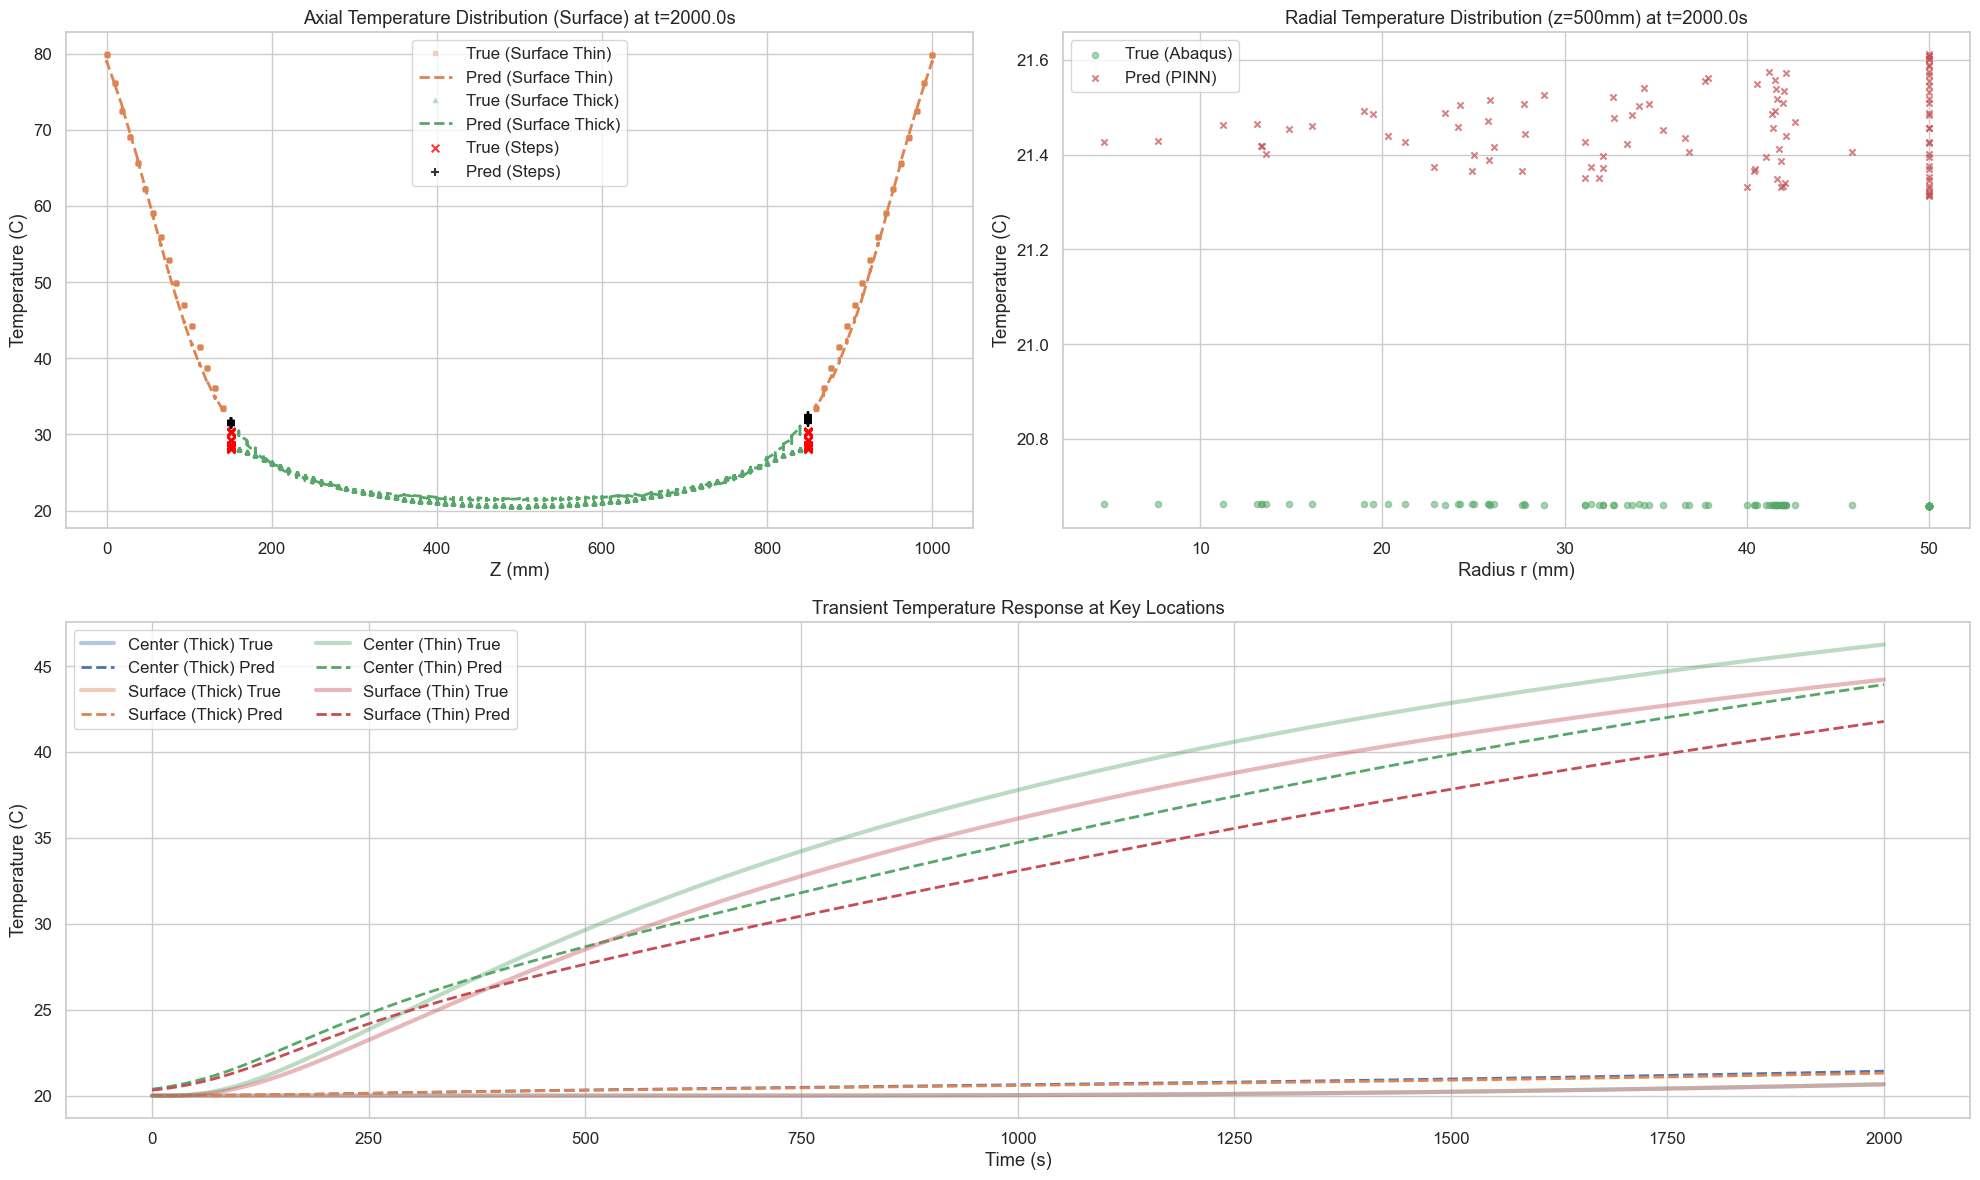


📊 评估完成！所有结果已保存至: c:\AAPostgraduate\PINNS-TORCH\pinns-torch\shaft-heat-transfer\plot\eval_20251125_151227


In [9]:
# --- 修正后的评估代码 (优化输出版 + 自动保存 + 使用已创建的评估目录) ---
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

# --- 0. 使用训练时创建的评估目录 ---
print(f"📊 评估结果将保存至: {CURRENT_EVAL_DIR}")

# --- [新增] 保存超参数 ---
import json
hyperparams = {
    "physics": {
        "rho": rho, "cp": cp, "k": k,
        "q_n": q_n, "h": h, "T_inf": T_inf
    },
    "network": {
        "layers": layers
    },
    "training": {
        "N_SENSORS": N_SENSORS,
        "N_PDE": N_PDE,
        "N_BC_ENDS": N_BC_ENDS,
        "N_BC_STEPS": N_BC_STEPS,
        "N_BC_SIDES": N_BC_SIDES,
        "MAX_EPOCHS": MAX_EPOCHS,
        "weights": {
            "pde_weight": PDE_WEIGHT,
            "bc_scale_general": BC_SCALE_GENERAL,
            "bc_scale_steps": BC_SCALE_STEPS
        }
    }
}

with open(CURRENT_EVAL_DIR / "hyperparameters.json", "w") as f:
    json.dump(hyperparams, f, indent=4)
print(f"✅ 已保存超参数配置: {CURRENT_EVAL_DIR / 'hyperparameters.json'}")

def predict_dataframe(model, df, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    辅助函数：直接对 DataFrame 进行预测
    """
    model.eval()
    model.to(device)
    
    # 准备输入数据
    x = torch.tensor(df['x'].values[:, None], dtype=torch.float32, device=device)
    y = torch.tensor(df['y'].values[:, None], dtype=torch.float32, device=device)
    z = torch.tensor(df['z'].values[:, None], dtype=torch.float32, device=device)
    t = torch.tensor(df['step_time'].values[:, None], dtype=torch.float32, device=device)
    
    # 预测
    with torch.no_grad():
        outputs = model(spatial=[x, y, z], time=t)
        pred_T = outputs['T'].cpu().numpy()
        
    return pred_T

print("\n正在进行全场预测 (Direct Inference)...")
# 使用全场数据 df_domain
pred_T = predict_dataframe(model, df_domain)

# 检查预测值的统计特性
print(f"预测值统计: Min={pred_T.min():.4f}, Max={pred_T.max():.4f}, Mean={pred_T.mean():.4f}, Std={pred_T.std():.4f}")

# 将预测结果填回 DataFrame
df_eval = df_domain.copy()
df_eval['pred_T'] = pred_T.flatten()
df_eval['abs_error'] = np.abs(df_eval['pred_T'] - df_eval['NT11'])

# --- 1. 区域误差统计汇总 ---
metrics_list = []

def get_metrics(name, df_subset):
    if len(df_subset) == 0:
        return {"Region": name, "Count": 0}
    
    mae = df_subset['abs_error'].mean()
    rmse = np.sqrt((df_subset['abs_error']**2).mean())
    max_error = df_subset['abs_error'].max()
    mean_true = df_subset['NT11'].mean()
    rel_error = mae / mean_true if mean_true != 0 else np.nan
    
    return {
        "Region": name,
        "Count": len(df_subset),
        "MAE (C)": mae,
        "RMSE (C)": rmse,
        "Max Error (C)": max_error,
        "Rel Error": rel_error
    }

# 全场
metrics_list.append(get_metrics("全场 (Global)", df_eval))

# 重新定义几何掩码
TOL = 1.0
df_eval["r"] = np.sqrt(df_eval["x"]**2 + df_eval["y"]**2)

# 端面
mask_ends = np.isclose(df_eval["z"], 0, atol=TOL) | np.isclose(df_eval["z"], 1000, atol=TOL)
metrics_list.append(get_metrics("端面 (Ends)", df_eval[mask_ends]))

# 细轴侧面
mask_thin_sides = np.isclose(df_eval["r"], 25, atol=TOL) & (
    ((df_eval["z"] > -TOL) & (df_eval["z"] < 150+TOL)) | 
    ((df_eval["z"] > 850-TOL) & (df_eval["z"] < 1000+TOL))
)
metrics_list.append(get_metrics("细轴侧面 (Thin Shaft)", df_eval[mask_thin_sides]))

# 台阶面
mask_steps = (np.isclose(df_eval["z"], 150, atol=TOL) | np.isclose(df_eval["z"], 850, atol=TOL)) & (df_eval["r"] > 25 + TOL)
metrics_list.append(get_metrics("台阶面 (Steps)", df_eval[mask_steps]))

# 粗轴侧面
mask_thick_sides = np.isclose(df_eval["r"], 50, atol=TOL) & (df_eval["z"] > 150-TOL) & (df_eval["z"] < 850+TOL)
metrics_list.append(get_metrics("粗轴侧面 (Thick Shaft)", df_eval[mask_thick_sides]))

# 显示统计表格
metrics_df = pd.DataFrame(metrics_list)
print("\n" + "="*70)
print("区域误差统计汇总")
print("="*70)
format_dict = {
    "MAE (C)": "{:.4f}", 
    "RMSE (C)": "{:.4f}", 
    "Max Error (C)": "{:.4f}", 
    "Rel Error": "{:.2%}"
}
try:
    display(metrics_df.style.format(format_dict))
except:
    print(metrics_df.to_string(formatters={k: v.format for k, v in format_dict.items()}))

# [保存] 误差统计表
metrics_df.to_csv(CURRENT_EVAL_DIR / "metrics_summary.csv", index=False)
print(f"✅ 已保存误差统计表: {CURRENT_EVAL_DIR / 'metrics_summary.csv'}")


# --- 2. 关键区域点抽样对比 ---
print("\n" + "="*70)
print("关键区域抽样对比 (各取 5 点)")
print("="*70)

def print_comparison_table(name, df_subset, n=5):
    count = len(df_subset)
    print(f"\n[{name}] (Total points: {count})")
    if count == 0:
        print(f"  无数据满足条件")
        return
    
    sample = df_subset.sample(n=min(n, count), random_state=42)
    
    cols = ['x', 'y', 'z', 'step_time', 'NT11', 'pred_T', 'abs_error']
    header = ['x', 'y', 'z', 'time', 'True', 'Pred', 'Diff']
    
    print_df = sample[cols].copy()
    print_df.columns = header
    print(print_df.to_string(index=False, float_format=lambda x: f"{x:.2f}"))
    
    # [保存] 抽样数据
    safe_name = name.split(' ')[0].replace("(", "").replace(")", "")
    sample.to_csv(CURRENT_EVAL_DIR / f"sample_{safe_name}.csv", index=False)

# (1) 端面
print_comparison_table("端面 (Ends)", df_eval[mask_ends])

# (2) 细轴 (中间段)
mask_thin = np.isclose(df_eval["r"], 25, atol=1.0) & ((df_eval["z"] > 50) & (df_eval["z"] < 100) | (df_eval["z"] > 900) & (df_eval["z"] < 950))
print_comparison_table("细轴 (Thin Shaft - Mid)", df_eval[mask_thin])

# (3) 粗轴 (中间段)
mask_thick = (df_eval["r"] > 45.0) & (df_eval["z"] > 400) & (df_eval["z"] < 600)
print_comparison_table("粗轴 (Thick Shaft - Mid)", df_eval[mask_thick])


# --- 3. 曲线绘制 (优化版) ---
import seaborn as sns
# 设置绘图风格
sns.set_theme(style="whitegrid", context="notebook", font_scale=1.1)
colors = sns.color_palette("deep")

# 准备数据：计算半径 r
df_eval['r'] = np.sqrt(df_eval['x']**2 + df_eval['y']**2)

# 创建画布
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])

# --- (A) 轴向温度分布 (Axial Distribution: T vs Z) ---
# 选择一个时间步 (稳态或接近稳态)
target_time_spatial = 2000.0
times = np.sort(df_eval['step_time'].unique())
viz_time = times[np.argmin(np.abs(times - target_time_spatial))]
df_viz = df_eval[df_eval['step_time'] == viz_time].copy()

ax1 = fig.add_subplot(gs[0, 0])

# 1. 外表面 (Outer Surface) - 分段处理
# 细轴左段 (Left Thin Shaft): r ~ 25, z < 150
mask_surf_thin_L = np.isclose(df_viz['r'], 25, atol=2.0) & (df_viz['z'] < 150)
df_surf_thin_L = df_viz[mask_surf_thin_L].sort_values('z')

# 细轴右段 (Right Thin Shaft): r ~ 25, z > 850
mask_surf_thin_R = np.isclose(df_viz['r'], 25, atol=2.0) & (df_viz['z'] > 850)
df_surf_thin_R = df_viz[mask_surf_thin_R].sort_values('z')

# 粗轴段 (Thick Shaft): r ~ 50, 150 < z < 850
mask_surf_thick = np.isclose(df_viz['r'], 50, atol=2.0) & (df_viz['z'] > 150) & (df_viz['z'] < 850)
df_surf_thick = df_viz[mask_surf_thick].sort_values('z')

# 台阶面 (Step Faces): z ~ 150 or z ~ 850, 25 < r < 50
mask_steps = (np.isclose(df_viz['z'], 150, atol=2.0) | np.isclose(df_viz['z'], 850, atol=2.0)) & \
             (df_viz['r'] > 25) & (df_viz['r'] < 50)
df_steps = df_viz[mask_steps].sort_values('r')

# 绘图 - Surface (Thin)
if not df_surf_thin_L.empty:
    ax1.plot(df_surf_thin_L['z'], df_surf_thin_L['NT11'], 's', color=colors[1], markersize=3, alpha=0.3, label='True (Surface Thin)')
    ax1.plot(df_surf_thin_L['z'], df_surf_thin_L['pred_T'], '--', color=colors[1], linewidth=2, label='Pred (Surface Thin)')
if not df_surf_thin_R.empty:
    ax1.plot(df_surf_thin_R['z'], df_surf_thin_R['NT11'], 's', color=colors[1], markersize=3, alpha=0.3)
    ax1.plot(df_surf_thin_R['z'], df_surf_thin_R['pred_T'], '--', color=colors[1], linewidth=2)

# 绘图 - Surface (Thick)
if not df_surf_thick.empty:
    ax1.plot(df_surf_thick['z'], df_surf_thick['NT11'], '^', color=colors[2], markersize=3, alpha=0.3, label='True (Surface Thick)')
    ax1.plot(df_surf_thick['z'], df_surf_thick['pred_T'], '--', color=colors[2], linewidth=2, label='Pred (Surface Thick)')

# 绘图 - Steps (Vertical Scatter)
if not df_steps.empty:
    ax1.scatter(df_steps['z'], df_steps['NT11'], color='red', s=30, marker='x', alpha=0.8, label='True (Steps)')
    ax1.scatter(df_steps['z'], df_steps['pred_T'], color='black', s=30, marker='+', alpha=0.8, label='Pred (Steps)')

ax1.set_title(f'Axial Temperature Distribution (Surface) at t={viz_time}s')
ax1.set_xlabel('Z (mm)')
ax1.set_ylabel('Temperature (C)')
ax1.legend()

# --- (B) 径向温度分布 (Radial Distribution: T vs r) ---
ax2 = fig.add_subplot(gs[0, 1])
# 取中间截面 z=500 +/- 5mm
mask_section = np.abs(df_viz['z'] - 500) < 5.0
df_section = df_viz[mask_section].sort_values('r')

if not df_section.empty:
    # 真实值用散点 (展示所有角度的数据)
    ax2.scatter(df_section['r'], df_section['NT11'], color=colors[2], s=20, alpha=0.5, label='True (Abaqus)')
    # 预测值用线 (理论上应该是平滑曲线)
    ax2.scatter(df_section['r'], df_section['pred_T'], color=colors[3], s=20, marker='x', alpha=0.7, label='Pred (PINN)')
    
ax2.set_title(f'Radial Temperature Distribution (z=500mm) at t={viz_time}s')
ax2.set_xlabel('Radius r (mm)')
ax2.set_ylabel('Temperature (C)')
ax2.legend()

# --- (C) 瞬态响应 (Transient Response: T vs Time) ---
ax3 = fig.add_subplot(gs[1, :])

# 定义探测点
probes = [
    ('Center (Thick)', 0, 0, 500),
    ('Surface (Thick)', 50, 0, 500),
    ('Center (Thin)', 0, 0, 100),
    ('Surface (Thin)', 25, 0, 100)
]

for i, (label, tx, ty, tz) in enumerate(probes):
    # 寻找最近点
    dists = np.sqrt((df_eval['x']-tx)**2 + (df_eval['y']-ty)**2 + (df_eval['z']-tz)**2)
    closest_idx = dists.idxmin()
    node_data = df_eval.loc[closest_idx]
    
    # 提取时间历程
    mask_node = (np.isclose(df_eval['x'], node_data['x'])) & \
                (np.isclose(df_eval['y'], node_data['y'])) & \
                (np.isclose(df_eval['z'], node_data['z']))
    df_hist = df_eval[mask_node].sort_values('step_time')
    
    c = colors[i % len(colors)]
    ax3.plot(df_hist['step_time'], df_hist['NT11'], linestyle='-', color=c, alpha=0.4, linewidth=3, label=f'{label} True')
    ax3.plot(df_hist['step_time'], df_hist['pred_T'], linestyle='--', color=c, linewidth=2, label=f'{label} Pred')

ax3.set_title('Transient Temperature Response at Key Locations')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Temperature (C)')
ax3.legend(ncol=2)

plt.tight_layout()
# [保存] 2D 分析图
plt.savefig(CURRENT_EVAL_DIR / "2d_analysis_curves.png", dpi=300)
print(f"✅ 已保存 2D 分析图: {CURRENT_EVAL_DIR / '2d_analysis_curves.png'}")
plt.show()

print("\n" + "="*70)
print(f"📊 评估完成！所有结果已保存至: {CURRENT_EVAL_DIR}")
print("="*70)


In [ ]:
# --- 三维可视化 ---
import plotly.express as px
import plotly.io as pio
import datetime

# 设置默认渲染器
pio.renderers.default = "notebook"

# 尝试获取上一个单元格定义的保存路径，如果没有则新建
try:
    save_dir = CURRENT_EVAL_DIR
except NameError:
    PLOT_DIR = NOTEBOOK_DIR / "plot"
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    save_dir = PLOT_DIR / f"eval_{timestamp}"
    save_dir.mkdir(parents=True, exist_ok=True)
    print(f"注意：未检测到上一步的保存路径，已创建新路径: {save_dir}")

print(f"3D 可视化结果将保存至: {save_dir}")

# 选择一个时间步进行可视化
target_time = 2000.0 
times = np.sort(df_eval['step_time'].unique())
viz_time = times[np.argmin(np.abs(times - target_time))]
df_viz = df_eval[df_eval['step_time'] == viz_time].copy()

print(f"=== 三维可视化 (Time: {viz_time} s) ===")
print(f"可视化点数: {len(df_viz)}")

# 通用绘图设置
common_layout = dict(
    template="plotly_white", # 使用白色背景，更适合论文/报告
    height=800, # 增加高度，适应细长轴的几何特征
    scene=dict(
        xaxis_title='X (mm)',
        yaxis_title='Y (mm)',
        zaxis_title='Z (mm)',
        aspectmode='data', # 严格保持物理比例
        # 调整相机视角: 大幅拉远 (x=4.0, y=4.0) 以便看到全长，z=2.0 俯视
        camera=dict(
            eye=dict(x=4.0, y=4.0, z=2.0) 
        )
    ),
    margin=dict(l=0, r=0, b=0, t=50) # 减少留白
)

# 1. 全域仿真值 (Ground Truth)
fig1 = px.scatter_3d(
    df_viz, x='x', y='y', z='z', color='NT11',
    title=f'1. True Temperature Field (Abaqus) at t={viz_time}s',
    labels={'NT11': 'Temp (C)'},
    color_continuous_scale='Jet',
    opacity=1.0 # 增加不透明度，使颜色更实
)
# 去掉点的轮廓线，使渲染更平滑
fig1.update_traces(marker=dict(size=4, line=dict(width=0))) 
fig1.update_layout(**common_layout)
fig1.show()

# 2. 预测值 (Prediction)
fig2 = px.scatter_3d(
    df_viz, x='x', y='y', z='z', color='pred_T',
    title=f'2. Predicted Temperature Field (PINN) at t={viz_time}s',
    labels={'pred_T': 'Temp (C)'},
    color_continuous_scale='Jet', 
    range_color=[df_viz['NT11'].min(), df_viz['NT11'].max()], # 统一量程方便对比
    opacity=1.0
)
fig2.update_traces(marker=dict(size=4, line=dict(width=0)))
fig2.update_layout(**common_layout)
fig2.show()

# 3. 误差分布 (Error)
fig3 = px.scatter_3d(
    df_viz, x='x', y='y', z='z', color='abs_error',
    title=f'3. Absolute Error Distribution at t={viz_time}s',
    labels={'abs_error': 'Error (C)'},
    color_continuous_scale='Viridis', # 误差使用 Viridis 色标
    opacity=1.0
)
fig3.update_traces(marker=dict(size=4, line=dict(width=0)))
fig3.update_layout(**common_layout)
fig3.show()

# [保存] 3D 图表
fig1.write_html(save_dir / "3d_true_temp.html")
fig2.write_html(save_dir / "3d_pred_temp.html")
fig3.write_html(save_dir / "3d_error.html")
print(f"已保存 3D 交互式图表 (HTML) 至: {save_dir}")